In [9]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv,GATConv, GNNExplainer
from torch.nn import Sequential, Linear

import random
import os
import matplotlib.pyplot as plt
import networkx as nx
import csv
import numpy as np

import dgl
import dgl.function as fn

from torch.utils.tensorboard import SummaryWriter

In [10]:

def build_circuit_graph_undirected(node_list,edge_list):
    g = dgl.DGLGraph()
    g.add_nodes(len(node_list))
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    g.add_edges(dst, src)
    return g

def build_circuit_graph_directed_sd(node_list,edge_list):
    g = dgl.DGLGraph()
    g.add_nodes(len(node_list))
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    return g

def build_circuit_graph_directed_ds(node_list,edge_list):
    g = dgl.DGLGraph()
    g.add_nodes(len(node_list))
    src, dst = tuple(zip(*edge_list))
    g.add_edges(dst, src)
    return g


In [11]:

dir = './preprocessing/processed_training_data_with_nodelabels'

trainset=[]
labels=[]
#for filename in os.listdir(dir):
np.random.seed(2) #original=1
sample_size = 1
training_idx = np.random.randint(4,64,10)
training_idx_1 = np.random.choice(training_idx, size=sample_size, replace=False)
# training_idx_2 = np.random.choice(training_idx, size=sample_size, replace=False)
# training_idx_3 = np.random.choice(training_idx, size=sample_size, replace=False)
# training_idx_4 = np.random.choice(training_idx, size=sample_size, replace=False)

training_idx_2 = training_idx_1
training_idx_3 = training_idx_1
training_idx_4 = training_idx_1
# training_idx_1 = [6]
# training_idx_2 = [6]
# training_idx_3 = [6]
# training_idx_4 = [6]
print(training_idx_1,training_idx_2,training_idx_3,training_idx_4)

[44] [44] [44] [44]


In [12]:
labels_list=[]

node_list=[]
edge_list=[]

for j in ["node_list","edge_list","gate_type"]:
    filename = "rca_"+str(4)+"bit"+j+'.csv'
    if(filename.find("node_list")>=0):
        with open(dir+'/'+filename, 'rt') as fh:
            reader=csv.reader(fh)
            node_list = list(reader)
            nodes = np.array(node_list)[0:,0]
            labels = np.array(node_list)[0:,1]
            label_tensor=torch.zeros(len(labels))
            for index,i in enumerate(labels):
                if (i=='0'):
                    label_tensor[index]=0
                elif(i=='1'):
                    label_tensor[index]=1
                else:
                    label_tensor[index]=2
    if(filename.find("edge_list")>=0):
        with open(dir+'/'+filename, 'rt') as fh:
            reader=csv.reader(fh)
            edge_list = list(reader)
    if(filename.find("gate_type")>=0):
        with open(dir+'/'+filename, 'rt') as fh:
            reader=csv.reader(fh)
            gate_type = list(reader)
            feature = torch.zeros(len(gate_type),35)
            for index,i in enumerate(gate_type):
                x = torch.zeros(1,35)
                x[0,int(gate_type[index][0])] = 1
                feature[index] = x


#create dgl graph
# g=build_circuit_graph_undirected(nodes,edge_list)
# trainset.append(g)
# labels_list.append(label_tensor)

### Load Training Data

In [13]:
labels_list=[]
feature_list=[]
trainset=[]
for idx in range(len(training_idx_1)):
    node_list=[]
    edge_list=[]

    for j in ["node_list","edge_list","gate_type"]:
        filename = "rca_"+str(training_idx_1[idx])+"bit"+j+'.csv'
        if(filename.find("node_list")>=0):
            with open(dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                node_list = list(reader)
                nodes = np.array(node_list)[0:,0]
                labels = np.array(node_list)[0:,1]
                label_tensor=torch.zeros(len(labels))
                for index,i in enumerate(labels):
                    if (i=='0'):
                        label_tensor[index]=0
                    elif(i=='1'):
                        label_tensor[index]=1
                    else:
                        label_tensor[index]=2
        if(filename.find("edge_list")>=0):
            with open(dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                edge_list = list(reader)
        if(filename.find("gate_type")>=0):
            with open(dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                gate_type = list(reader)
                feature = torch.zeros(len(gate_type),37)
                for index,i in enumerate(gate_type):
                    x = torch.zeros(1,37)
                    x[0,int(gate_type[index][0])] = 1
                    feature[index] = x
                

    #create dgl graph
    g=build_circuit_graph_undirected(nodes,edge_list)
    trainset.append(g)
    labels_list.append(label_tensor)
    feature_list.append(feature)

In [14]:
labels_list

[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2.,

In [15]:
class Net(torch.nn.Module):
    def __init__(self,in_dim,hidden_dim,out_dim):
        super(Net, self).__init__()
        self.lin = Sequential(Linear(10, 10))
        self.conv1 = GATConv(in_dim, hidden_dim)
        self.conv2 = GATConv(hidden_dim, out_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

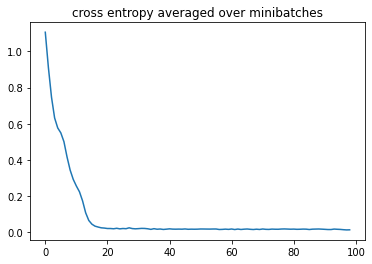

In [16]:
writer = SummaryWriter()
loss_func = torch.nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(37,512,3).to(device)
# data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# x, edge_index = data.x, data.edge_index
epoch_losses = []
for epoch in range(1, 100):
    epoch_loss = 0
    for iter, bg in enumerate(trainset):
        model.train()
        optimizer.zero_grad()
        #using indegree as features
#         x = bg.in_degrees().view(-1, 1).float()
        x = feature_list[iter]
        
        a = bg.edges()[0].tolist()
        b = bg.edges()[1].tolist()
        edges = list(zip(a,b))
        edges = np.array(edges)
        edges = torch.LongTensor(edges.transpose())

        log_logits = model(x, edges)
        
        label_tensor = labels_list[iter].long()

        loss = F.nll_loss(log_logits, label_tensor)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
        
        writer.add_scalar('Loss/train', loss.detach().item(), epoch)
    epoch_loss /= (iter + 1)
    epoch_losses.append(epoch_loss)
    writer.add_scalar('Loss/train', epoch_loss,epoch)
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

In [17]:

for j in ["node_list","edge_list","gate_type"]:
    filename = "csa_"+str(16)+"bit"+j+'.csv'
    if(filename.find("node_list")>=0):
                with open(dir+'/'+filename, 'rt') as fh:
                    reader=csv.reader(fh)
                    node_list = list(reader)
                    nodes = np.array(node_list)[0:,0]
                    labels = np.array(node_list)[0:,1]
                    label_tensor=torch.zeros(len(labels),1)
                    for index,i in enumerate(labels):
                        if (i=='0'):
                            label_tensor[index]=0
                        elif(i=='1'):
                            label_tensor[index]=1
                        else:
                            label_tensor[index]=2
    if(filename.find("edge_list")>=0):
                with open(dir+'/'+filename, 'rt') as fh:
                    reader=csv.reader(fh)
                    edge_list = list(reader)
    if(filename.find("gate_type")>=0):
            with open(dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                gate_type = list(reader)
                feature = torch.zeros(len(gate_type),37)
                for index,i in enumerate(gate_type):
                    x = torch.zeros(1,37)
                    x[0,int(gate_type[index][0])] = 1
                    feature[index] = x
test_g=build_circuit_graph_undirected(nodes,edge_list)



In [18]:
model.eval()
x = feature
a = test_g.edges()[0].tolist()
b = test_g.edges()[1].tolist()
edges= list(zip(a,b))
edges=np.array(edges)
edges=torch.LongTensor(edges.transpose())
probs_Y = model(x, edges)

#Add to tensorboard
writer.add_embedding(probs_Y,label_tensor,tag='output')
writer.add_graph(model,(x,edges))
writer.close()

/home/gpu-user-02/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/tensor.py:464: RuntimeWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  warnings.warn('Iterating over a tensor might cause the trace to be incorrect. '


In [19]:


# sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
# print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
#     (label_tensor == sampled_Y.float()).sum().item() / len(label_tensor) * 100))
print('Accuracy of argmax predictions on the test set: {:.4f}%'.format(
    (label_tensor == argmax_Y.float()).sum().item() / len(label_tensor) * 100))

print(len(label_tensor))
# print(log_logits)

Accuracy of argmax predictions on the test set: 99.7297%
370


In [20]:
error = (label_tensor != argmax_Y.float()).nonzero()
print('Total', len(error),'errors out of',len(label_tensor),'test data')
for i in error.cpu().numpy():
    error_idx= i[0]
    print(probs_Y[error_idx],label_tensor[error_idx])
    print(error_idx)

Total 1 errors out of 370 test data
tensor([-0.1185, -5.3298, -2.2356], grad_fn=<SelectBackward>) tensor([2.])
317


Explain node 366: 100%|██████████| 200/200 [00:00<00:00, 261.89it/s]


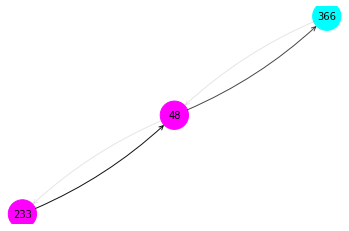

In [28]:
## model.eval()
# x = g.in_degrees().view(-1, 1).float()
x = feature
a = test_g.edges()[0].tolist()
b = test_g.edges()[1].tolist()
edges= list(zip(a,b))
edges=np.array(edges)
edges=torch.LongTensor(edges.transpose())
probs_Y = model(x, edges)

explainer = GNNExplainer(model, epochs=200)
node_idx = 366
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edges)


plt = explainer.visualize_subgraph(node_idx, edge_index=edges, edge_mask=edge_mask, y=label_tensor,threshold=None)
plt.show()

In [29]:
edge_mask

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [201]:
GCN1_act = []
GCN2_act = []
graph_emb = []
final_class = []

def get_activation_1(self,input,output):
    print(output.size())
    GCN1_act.append(output.data.cpu().numpy())
    
def get_activation_2(self,input,output):
    print(output.size())
    GCN2_act.append(output.data.cpu().numpy())
    
def get_activation_3(self,input,output):
    print(output.size())
    graph_emb.append(input[0].cpu().detach().numpy())
    final_class.append(output.data.cpu().numpy())

In [202]:
h1 = model.conv1.register_forward_hook(get_activation_1)
h2 = model.conv2.register_forward_hook(get_activation_2)
# h3 = model.classify.register_forward_hook(get_activation_3)

# for i in range(len(testset)):
#     out = model(testset[i])

In [73]:
probs_Y = model(x, edges)

torch.Size([149, 512])
torch.Size([149, 3])


In [74]:
len(GCN1_act),len(GCN2_act)

(1, 1)

In [75]:
GCN1_act[0]
writer.add_embedding(GCN1_act[0],label_tensor,tag='GCN1')

In [76]:
GCN2_act
writer.add_embedding(GCN2_act[0],label_tensor,tag='GCN2')

In [77]:
GCN2_act

[array([[ -2.538664  ,  -7.037983  ,   9.469903  ],
        [ -2.1842594 ,  -3.541679  ,   5.6376457 ],
        [ -2.370746  ,  -7.333452  ,   9.59091   ],
        [ -2.285308  ,  -7.0473957 ,   9.222534  ],
        [ -2.4004745 ,  -6.7464137 ,   9.033851  ],
        [ -2.2628157 ,  -7.020892  ,   9.166858  ],
        [ -2.1996596 ,  -6.7635417 ,   8.865248  ],
        [ -2.3223639 ,  -7.0004244 ,   9.21385   ],
        [ -2.232582  ,  -6.549302  ,   8.665788  ],
        [ -2.3330593 ,  -6.8349013 ,   9.048173  ],
        [ -2.311273  ,  -7.263563  ,   9.4718485 ],
        [ -2.2645824 ,  -6.6593857 ,   8.814188  ],
        [ -2.253508  ,  -6.91223   ,   9.055968  ],
        [ -2.3540523 ,  -7.3466063 ,   9.586225  ],
        [ -2.2424726 ,  -7.0815406 ,   9.211971  ],
        [ -2.417153  ,  -6.788133  ,   9.089881  ],
        [ -2.3190393 ,  -6.907757  ,   9.113196  ],
        [ -2.2525532 ,  -6.842358  ,   8.992695  ],
        [ -2.3509257 ,  -6.884099  ,   9.130473  ],
        [ -2